In [1]:
!pip install ffmpeg-python
!pip install SpeechRecognition
!pip install openai-whisper --no-cache-dir

!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/examples/dreambooth/train_dreambooth.py
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/scripts/convert_diffusers_to_original_stable_diffusion.py

%pip install -qq git+https://github.com/ShivamShrirao/diffusers

%pip install -q -U --pre triton
%pip install -q accelerate transformers ftfy bitsandbytes natsort safetensors xformers
!pip install huggingface_hub==0.23.5

!pip install "jax[cuda12_pip]==0.4.23" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 30.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 234.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 290.5 MB/s eta 0:00:00
  Created wheel for openai-whisper: filename=openai_whisper-20240930-py3-none-any.whl size=803320 sha256=9cdf45c46d87e353ac38bb9eb14523c0a1926b80250b69a3485c6fb07eba534d
  Stored in directory: /tmp/pip-ephem-wheel-cache-aztbr024/wheels/dd/4a/1f/d1c4bf3b9133c8168fe617ed979cab7b14fe381d059ffb9d83
Successfully built openai-whisper
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.9 MB/s eta 0:00:00


In [2]:
import argparse
import io
import os
import speech_recognition as sr
import whisper
import torch
import time
from datetime import datetime, timedelta
from queue import Queue
from tempfile import NamedTemporaryFile
from sys import platform
import json
from google.colab import files
import shutil
from natsort import natsorted
from glob import glob
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, DDIMScheduler


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
def speech_to_text(audio, sr, whisper_model="tiny", duration=10):
    """
    Transcribes audio data using the Whisper model.

    Args:
        audio: NumPy array containing audio data.
        sr: Sample rate of the audio data.
        whisper_model: Name of the Whisper model to use.
        duration: Maximum duration of the transcription in seconds.

    Returns:
        A list of transcribed text segments.
    """

    # Load Whisper model
    model = whisper.load_model(whisper_model)

    # Create a temporary file to store audio data
    temp_file = NamedTemporaryFile().name
    from scipy.io.wavfile import write as wav_write
    wav_write(temp_file, sr, audio)

    # Transcribe audio using Whisper
    result = model.transcribe(temp_file, fp16=torch.cuda.is_available())

    # Return the transcribed text
    return result['text'].strip()


def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr


from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""



In [5]:
WEIGHTS_DIR = "/content/gdrive/MyDrive/ECE-5831/stable_diffusion2/stable_diffusion_weights/model/1500"
ckpt_path = WEIGHTS_DIR + "/model.ckpt"
model_path = WEIGHTS_DIR

pipe = StableDiffusionPipeline.from_pretrained(model_path, safety_checker=None,
                                               torch_dtype=torch.float16
                                              ).to("cuda")
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.enable_xformers_memory_efficient_attention()

g_cuda = torch.Generator(device='cuda')
seed = 52362
g_cuda.manual_seed(seed)

/usr/local/lib/python3.10/dist-packages/diffusers/models/modeling_utils.py:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location

/usr/local/lib/python3.10/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=device)


in mountains.


  0%|          | 0/24 [00:00<?, ?it/s]

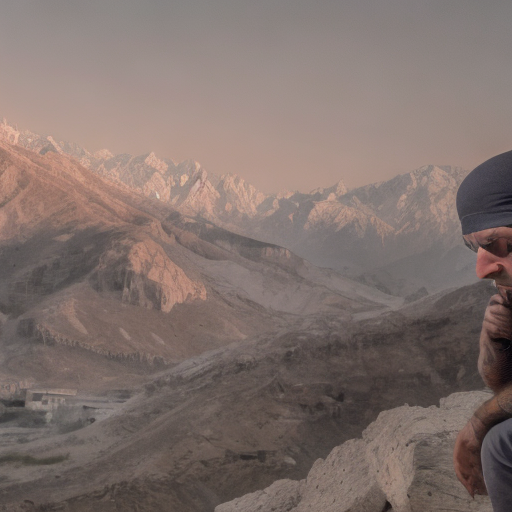

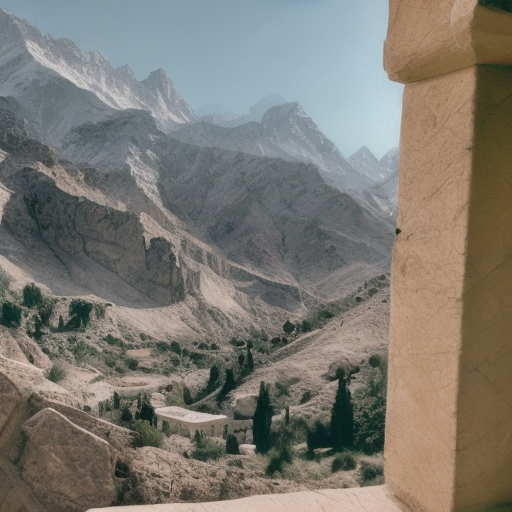

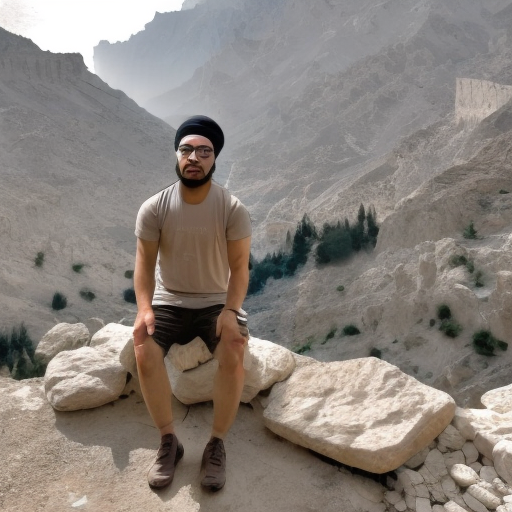

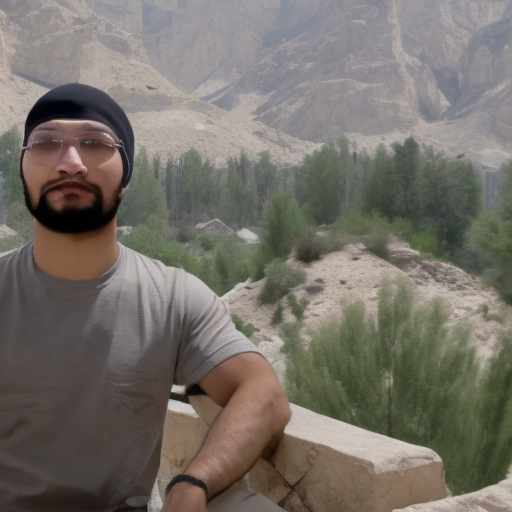

In [14]:
audio, sr = get_audio()
text_prompt = speech_to_text(audio, sr)

print(text_prompt)
prompt =  "jaskirat " + text_prompt
negative_prompt = ""
num_samples = 4
guidance_scale = 7.5
num_inference_steps = 24
height = 512
width = 512

with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

for img in images:
    display(img)


